In [1]:
# Import necessary libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import gc
import joblib
import os
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from xgboost import XGBClassifier

## Data Loading

In [2]:
# Define the path for the feature names CSV file
features_file = 'input/NUSW-NB15_features.csv'

# Load feature names from the CSV file
features_df = pd.read_csv(features_file, encoding='ISO-8859-1')

# Process the column names to remove spaces and convert to lower case
column_names = features_df['Name'].apply(lambda x: x.strip().replace(' ', '').lower())

# Gather all dataset CSV file paths excluding the features file
dataset_paths = [os.path.join('input', filename) for filename in os.listdir('input') if filename.endswith('.csv') and filename != 'NUSW-NB15_features.csv']

# Initialize an empty DataFrame to store the merged data
complete_df = pd.DataFrame()

# Load each dataset and concatenate it into complete_df
for file in dataset_paths:
    df = pd.read_csv(file, header=None, names=column_names)
    complete_df = pd.concat([complete_df, df], ignore_index=True)
    print(f"Successfully loaded {file}")

print(complete_df.shape)

C:\Users\Jeffson\AppData\Local\Temp\ipykernel_4492\4200030863.py:18: DtypeWarning: Columns (1,3,47) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file, header=None, names=column_names)


Successfully loaded input\UNSW-NB15_1.csv


C:\Users\Jeffson\AppData\Local\Temp\ipykernel_4492\4200030863.py:18: DtypeWarning: Columns (3,39,47) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file, header=None, names=column_names)


Successfully loaded input\UNSW-NB15_2.csv
Successfully loaded input\UNSW-NB15_3.csv
Successfully loaded input\UNSW-NB15_4.csv
(2540047, 49)


# Data Preprocessing

In [3]:
complete_df.isnull().sum()

srcip                     0
sport                     0
dstip                     0
dsport                    0
proto                     0
state                     0
dur                       0
sbytes                    0
dbytes                    0
sttl                      0
dttl                      0
sloss                     0
dloss                     0
service                   0
sload                     0
dload                     0
spkts                     0
dpkts                     0
swin                      0
dwin                      0
stcpb                     0
dtcpb                     0
smeansz                   0
dmeansz                   0
trans_depth               0
res_bdy_len               0
sjit                      0
djit                      0
stime                     0
ltime                     0
sintpkt                   0
dintpkt                   0
tcprtt                    0
synack                    0
ackdat                    0
is_sm_ips_ports     

## Cleaning null values

In [4]:
# fill Null values with '0' in 'ct_flw'http_mthd'
complete_df['ct_flw_http_mthd'] = complete_df.ct_flw_http_mthd.fillna(value=0)

# fill Null values with '0' in 'is_ftp_login'
complete_df['is_ftp_login'] = complete_df.is_ftp_login.fillna(value=0)

# fill Null values with 'normal' for normal attacks in 'attack_cat'
complete_df['attack_cat'] = complete_df.attack_cat.fillna(value='normal').apply(lambda x: x.strip().lower())

print('After cleaning null values: \n', complete_df.isnull().sum())

After cleaning null values: 
 srcip               0
sport               0
dstip               0
dsport              0
proto               0
state               0
dur                 0
sbytes              0
dbytes              0
sttl                0
dttl                0
sloss               0
dloss               0
service             0
sload               0
dload               0
spkts               0
dpkts               0
swin                0
dwin                0
stcpb               0
dtcpb               0
smeansz             0
dmeansz             0
trans_depth         0
res_bdy_len         0
sjit                0
djit                0
stime               0
ltime               0
sintpkt             0
dintpkt             0
tcprtt              0
synack              0
ackdat              0
is_sm_ips_ports     0
ct_state_ttl        0
ct_flw_http_mthd    0
is_ftp_login        0
ct_ftp_cmd          0
ct_srv_src          0
ct_srv_dst          0
ct_dst_ltm          0
ct_src_ltm          0
ct

## 'is_ftp_login' is a binary attribute but has values other than 0 and 1, so
##  any value greater than 1 is replaced with 1. Values that are 1 or less remain unchanged

In [5]:
print('Before: \n', complete_df['is_ftp_login'].value_counts())
complete_df['is_ftp_login'] = np.where(complete_df['is_ftp_login']>1, 1, complete_df['is_ftp_login'])

Before: 
 is_ftp_login
0.0    2496472
1.0      43389
4.0        156
2.0         30
Name: count, dtype: int64


In [6]:
print('After: \n', complete_df['is_ftp_login'].value_counts())

After: 
 is_ftp_login
0.0    2496472
1.0      43575
Name: count, dtype: int64


## ‘ct_ftp_cmd’ attribute has blank entries and it is supposed to be numerical

In [7]:
print('Entries in this attribute:', complete_df['ct_ftp_cmd'].unique())
print('Data type:', complete_df['ct_ftp_cmd'].dtype)
complete_df['ct_ftp_cmd'] = complete_df['ct_ftp_cmd'].replace(to_replace=' ', value=0).astype(int)

Entries in this attribute: [0 1 6 2 4 8 5 3 '0' '1' ' ' '2' '4']
Data type: object


In [8]:
print("After Cleaning 'ct_ftp_cmd'")
print('Entries in this attribute:', complete_df['ct_ftp_cmd'].unique())
print('Data type:', complete_df['ct_ftp_cmd'].dtype)

After Cleaning 'ct_ftp_cmd'
Entries in this attribute: [0 1 6 2 4 8 5 3]
Data type: int32


## 'service' is a categorical attribute but has value "-"

In [9]:
print('Before: \n', complete_df['service'].value_counts())
complete_df['service'] = complete_df['service'].apply(lambda x: "None" if x == "-" else x)

Before: 
 service
-           1246397
dns          781668
http         206273
ftp-data     125783
smtp          81645
ftp           49090
ssh           47160
pop3           1533
dhcp            172
ssl             142
snmp            113
radius           40
irc              31
Name: count, dtype: int64


In [10]:
print('After: \n', complete_df['service'].value_counts())

After: 
 service
None        1246397
dns          781668
http         206273
ftp-data     125783
smtp          81645
ftp           49090
ssh           47160
pop3           1533
dhcp            172
ssl             142
snmp            113
radius           40
irc              31
Name: count, dtype: int64


## Replace 'backdoors' attribute to the correct name 'backdoor'

In [11]:
print('Before:', complete_df['attack_cat'].value_counts())
complete_df['attack_cat'] = complete_df['attack_cat'].replace('backdoors','backdoor', regex=True).apply(lambda x: x.strip().lower())

Before: attack_cat
normal            2218764
generic            215481
exploits            44525
fuzzers             24246
dos                 16353
reconnaissance      13987
analysis             2677
backdoor             1795
shellcode            1511
backdoors             534
worms                 174
Name: count, dtype: int64


In [12]:
print('After:', complete_df['attack_cat'].value_counts())

After: attack_cat
normal            2218764
generic            215481
exploits            44525
fuzzers             24246
dos                 16353
reconnaissance      13987
analysis             2677
backdoor             2329
shellcode            1511
worms                 174
Name: count, dtype: int64


In [14]:
drop_cols = [
    # Features with high correlation (More et al., 2024)
    'sloss',
    'dloss',
    'dpkts',
    'dwin',
    'ltime',
    'ct_srv_dst',
    'ct_src_dport_ltm',
    'ct_dst_src_ltm',
    # Features providing individual session specific details
    'srcip',
    'sport',
    'dstip',
    'dsport',
]

In [15]:
# Dropping features
complete_df.drop(columns=drop_cols, inplace=True, errors='ignore')
print(f'Shape after dropping columns: {complete_df.shape}')

# Remove rows with 'NaN', '+inf', '-inf' values
complete_df.replace([np.inf, -np.inf], np.nan, inplace=True)
complete_df.dropna(inplace=True)
print(f'Shape after removing invalid data: {complete_df.shape}')

# Remove duplicate rows
complete_df.drop_duplicates(inplace=True)
complete_df.reset_index(drop=True, inplace=True)

print(f'Shape after removing duplicated rows: {complete_df.shape}')

Shape after dropping columns: (2540047, 37)
Shape after removing invalid data: (2540047, 37)
Shape after removing duplicated rows: (2057485, 37)


## Feature Encoding

In [16]:
complete_df.select_dtypes(exclude=np.number).columns

Index(['proto', 'state', 'service', 'attack_cat'], dtype='object')

In [17]:
# Fit and transform the 'attack_cat' column
label_encoder = LabelEncoder()
complete_df['attack_cat'] = label_encoder.fit_transform(complete_df['attack_cat'])

# Display unique classes after label encoding
print(f'Classes: {label_encoder.classes_}')
print(f'Encoded labels: {complete_df["attack_cat"].value_counts()}')

Classes: ['analysis' 'backdoor' 'dos' 'exploits' 'fuzzers' 'generic' 'normal'
 'reconnaissance' 'shellcode' 'worms']
Encoded labels: attack_cat
6    1958103
3      27596
5      25284
4      21637
7      13352
2       5665
0       2184
1       1983
8       1511
9        170
Name: count, dtype: int64


In [18]:
# Initialize OneHotEncoder
encoder = OneHotEncoder()

# Initialize an empty DataFrame to hold all new one-hot encoded features
encoded_features = pd.DataFrame()

categorical_features = ['proto', 'state', 'service']

# Fit and transform data
encoded_data = encoder.fit_transform(complete_df[categorical_features]).toarray()

# Generate correct column names using get_feature_names_out()
column_names = encoder.get_feature_names_out()

# Convert the encoded data into a DataFrame with appropriate column names
encoded_df = pd.DataFrame(encoded_data, columns=column_names)

# Drop the original categorical columns from complete_df
complete_df.drop(columns=categorical_features, inplace=True)

# Concatenate the original DataFrame with the new encoded DataFrame
complete_df = pd.concat([complete_df, encoded_df.reset_index(drop=True)], axis=1)

## Reduce dataset size by converting data types from int64 to int16 and float64 to float32

In [19]:
int_col = complete_df.select_dtypes(include='integer').columns
complete_df[int_col] = complete_df[int_col].astype('int16')

float_col = complete_df.select_dtypes(include='float').columns
complete_df[float_col] = complete_df[float_col].astype('float32')

## Split Data

In [19]:
# Retrieving Features and Labels
features = complete_df.drop(['attack_cat', 'label'], axis=1)
target = complete_df['attack_cat']

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=0)

## Standardization

In [20]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

1. X are the features, y is the target
2. The model learns patterns in features (X_train) and its corresponding target (y_train)
3. X_test and y_test are used to evaluate the model
4. The model predicts the target (y_predict) based on the features from unseen data (X_test) after learning the patterns during training
5. The predictions (y_predict) are then compared with (y_test) to see how well the model performs

## Model Training - Random Forest

In [27]:
# Train and evaluate Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1, class_weight='balanced')
rf_model.fit(X_train_scaled, y_train)
rf_y_predict = rf_model.predict(X_test_scaled)
print("Random Forest Classifier Report")
print(classification_report(y_test, rf_y_predict))

# Calculate metrics for Random Forest
rf_accuracy = accuracy_score(y_test, rf_y_predict)
rf_precision = precision_score(y_test, rf_y_predict, average='weighted')
rf_recall = recall_score(y_test, rf_y_predict, average='weighted')
rf_f1 = f1_score(y_test, rf_y_predict, average='weighted')

print("\nRandom Forest Classifier Metrics:")
print(f"Accuracy of Random Forest: {rf_accuracy:.4f}")
print(f"Precision of Random Forest: {rf_precision:.4f}")
print(f"Recall of Random Forest: {rf_recall:.4f}")
print(f"F1-measure of Random Forest: {rf_f1:.4f}")

# Save the model and clear memory
joblib.dump(rf_model, 'rf_model.pkl')
del rf_model
gc.collect()

Random Forest Classifier Report
              precision    recall  f1-score   support

           0       0.00      0.01      0.01       415
           1       0.04      0.11      0.06       432
           2       0.33      0.15      0.21      1149
           3       0.81      0.82      0.81      5478
           4       0.62      0.56      0.59      4296
           5       0.97      0.87      0.92      5007
           6       0.99      1.00      1.00    391741
           7       0.90      0.78      0.84      2662
           8       0.56      0.58      0.57       289
           9       0.62      0.29      0.39        28

    accuracy                           0.98    411497
   macro avg       0.58      0.52      0.54    411497
weighted avg       0.98      0.98      0.98    411497


Random Forest Classifier Metrics:
Accuracy of Random Forest: 0.9818
Precision of Random Forest: 0.9833
Recall of Random Forest: 0.9818
F1-measure of Random Forest: 0.9824


46

## Model Training - SVM

In [29]:
# Train and evaluate the SVM with LinearSVC
svm_model = LinearSVC(dual=False, class_weight='balanced')
svm_model.fit(X_train_scaled, y_train)
svm_y_predict = svm_model.predict(X_test_scaled)
print("SVM Classifier Report")
print(classification_report(y_test, svm_y_predict))

# Calculate metrics for the SVM
svm_accuracy = accuracy_score(y_test, svm_y_predict)
svm_precision = precision_score(y_test, svm_y_predict, average='weighted')
svm_recall = recall_score(y_test, svm_y_predict, average='weighted')
svm_f1 = f1_score(y_test, svm_y_predict, average='weighted')

print("\nSVM Classifier Metrics:")
print(f"Accuracy of SVM: {svm_accuracy:.4f}")
print(f"Precision of SVM: {svm_precision:.4f}")
print(f"Recall of SVM: {svm_recall:.4f}")
print(f"F1-measure of SVM: {svm_f1:.4f}")

# Save the model and clear memory
joblib.dump(svm_model, 'svm_model.pkl')
del svm_model
gc.collect()

c:\Users\Jeffson\miniconda3\Lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


SVM Classifier Report
              precision    recall  f1-score   support

           0       0.12      0.41      0.19       415
           1       0.12      0.28      0.17       432
           2       0.18      0.07      0.10      1149
           3       0.70      0.59      0.64      5478
           4       0.37      0.69      0.48      4296
           5       0.97      0.78      0.87      5007
           6       1.00      0.99      0.99    391741
           7       0.36      0.24      0.29      2662
           8       0.08      0.72      0.15       289
           9       0.01      0.61      0.02        28

    accuracy                           0.97    411497
   macro avg       0.39      0.54      0.39    411497
weighted avg       0.98      0.97      0.97    411497


SVM Classifier Metrics:
Accuracy of SVM: 0.9656
Precision of SVM: 0.9800
Recall of SVM: 0.9656
F1-measure of SVM: 0.9716


11903

## Model Training - Logistic Regression

In [26]:
# Train and evaluate Logistic Regression
logreg_model = LogisticRegression(max_iter=1000, random_state=0, class_weight='balanced')
logreg_model.fit(X_train_scaled, y_train)
logreg_y_predict = logreg_model.predict(X_test_scaled)
print("Logistic Regression Classifier Report")
print(classification_report(y_test, logreg_y_predict))

# Calculate metrics for Logistic Regression
logreg_accuracy = accuracy_score(y_test, logreg_y_predict)
logreg_precision = precision_score(y_test, logreg_y_predict, average='weighted')
logreg_recall = recall_score(y_test, logreg_y_predict, average='weighted')
logreg_f1 = f1_score(y_test, logreg_y_predict, average='weighted')

print("\nLogistic Regression Classifier Metrics:")
print(f"Accuracy of Logistic Regression: {logreg_accuracy:.4f}")
print(f"Precision of Logistic Regression: {logreg_precision:.4f}")
print(f"Recall of Logistic Regression: {logreg_recall:.4f}")
print(f"F1-measure of Logistic Regression: {logreg_f1:.4f}")

# Save the model and clear memory
joblib.dump(logreg_model, 'logreg_model.pkl')
del logreg_model
gc.collect()

c:\Users\Jeffson\miniconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Classifier Report
              precision    recall  f1-score   support

           0       0.12      0.54      0.19       415
           1       0.12      0.33      0.18       432
           2       0.10      0.05      0.06      1149
           3       0.73      0.57      0.64      5478
           4       0.39      0.61      0.48      4296
           5       0.97      0.78      0.86      5007
           6       1.00      0.98      0.99    391741
           7       0.37      0.33      0.35      2662
           8       0.07      0.78      0.13       289
           9       0.01      0.79      0.02        28

    accuracy                           0.96    411497
   macro avg       0.39      0.58      0.39    411497
weighted avg       0.98      0.96      0.97    411497


Logistic Regression Classifier Metrics:
Accuracy of Logistic Regression: 0.9643
Precision of Logistic Regression: 0.9806
Recall of Logistic Regression: 0.9643
F1-measure of Logistic Regression: 0.9714


3603

## Model Training - XGBoost

In [21]:
# Train and evaluate XGBoost model
xgb_model = XGBClassifier(random_state=0, use_label_encoder=False, eval_metric='mlogloss', nthread=-1)
xgb_model.fit(X_train_scaled, y_train)
xgb_y_predict = xgb_model.predict(X_test_scaled)
print("XGBoost Classifier Report")
print(classification_report(y_test, xgb_y_predict))

# Calculate metrics for XGBoost
xgb_accuracy = accuracy_score(y_test, xgb_y_predict)
xgb_precision = precision_score(y_test, xgb_y_predict, average='weighted')
xgb_recall = recall_score(y_test, xgb_y_predict, average='weighted')
xgb_f1 = f1_score(y_test, xgb_y_predict, average='weighted')

print("\nXGBoost Classifier Metrics:")
print(f"Accuracy of XGBoost: {xgb_accuracy:.4f}")
print(f"Precision of XGBoost: {xgb_precision:.4f}")
print(f"Recall of XGBoost: {xgb_recall:.4f}")
print(f"F1-measure of XGBoost: {xgb_f1:.4f}")

# Save the model and clear memory
joblib.dump(xgb_model, 'xgb_model.pkl')
del xgb_model
gc.collect()

XGBoost Classifier Report
              precision    recall  f1-score   support

           0       0.08      0.11      0.09       415
           1       0.17      0.14      0.15       432
           2       0.34      0.21      0.26      1149
           3       0.76      0.82      0.79      5478
           4       0.65      0.60      0.62      4296
           5       0.95      0.88      0.92      5007
           6       1.00      1.00      1.00    391741
           7       0.86      0.80      0.83      2662
           8       0.60      0.61      0.61       289
           9       0.54      0.50      0.52        28

    accuracy                           0.98    411497
   macro avg       0.60      0.57      0.58    411497
weighted avg       0.98      0.98      0.98    411497


XGBoost Classifier Metrics:
Accuracy of XGBoost: 0.9841
Precision of XGBoost: 0.9834
Recall of XGBoost: 0.9841
F1-measure of XGBoost: 0.9836


9

## Confusion Matrix

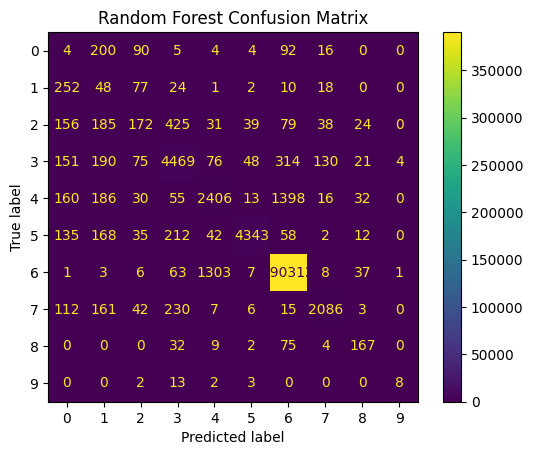

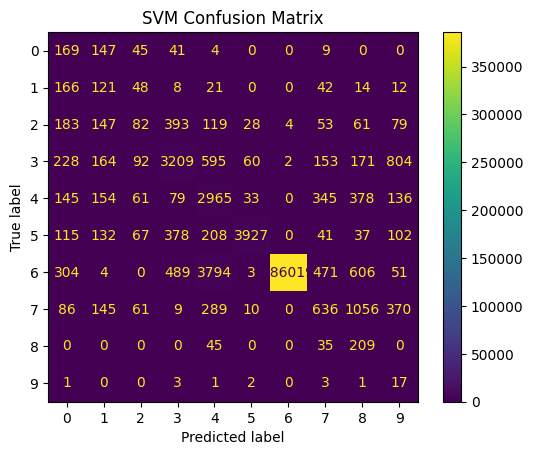

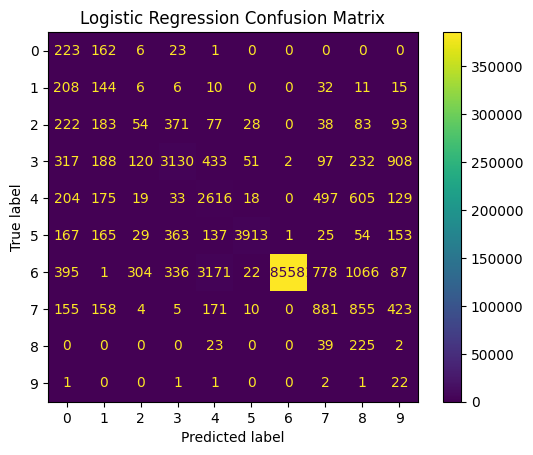

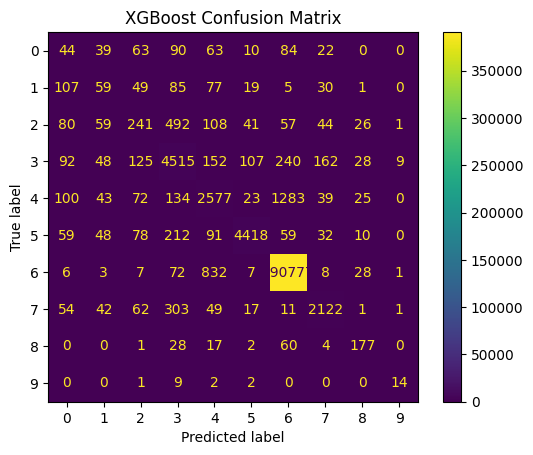

In [30]:
# Random Forest Classifier Confusion Matrix
rf_cm = confusion_matrix(y_test, rf_y_predict)
disp = ConfusionMatrixDisplay(confusion_matrix=rf_cm)
disp.plot()
plt.title('Random Forest Confusion Matrix')
plt.show()

# SVM Classifier Confusion Matrix
svm_cm = confusion_matrix(y_test, svm_y_predict)
disp = ConfusionMatrixDisplay(confusion_matrix=svm_cm)
disp.plot()
plt.title('SVM Confusion Matrix')
plt.show()

# Logistic Regression Classifier Confusion Matrix
logreg_cm = confusion_matrix(y_test, logreg_y_predict)
disp = ConfusionMatrixDisplay(confusion_matrix=logreg_cm)
disp.plot()
plt.title('Logistic Regression Confusion Matrix')
plt.show()

# XGBoost Classifier Confusion Matrix
xgb_cm = confusion_matrix(y_test, xgb_y_predict)
disp = ConfusionMatrixDisplay(confusion_matrix=xgb_cm)
disp.plot()
plt.title('XGBoost Confusion Matrix')
plt.show()

## Precision–Recall Curve (PRC)

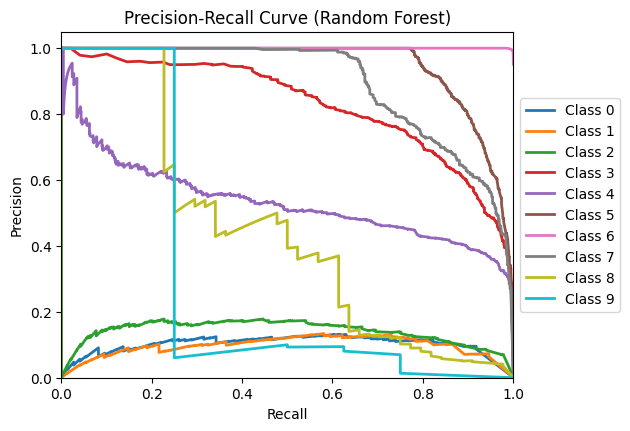

c:\Users\Jeffson\miniconda3\Lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Jeffson\miniconda3\Lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Jeffson\miniconda3\Lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Jeffson\miniconda3\Lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Jeffson\miniconda3\Lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Jeffson\miniconda3\Lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, in

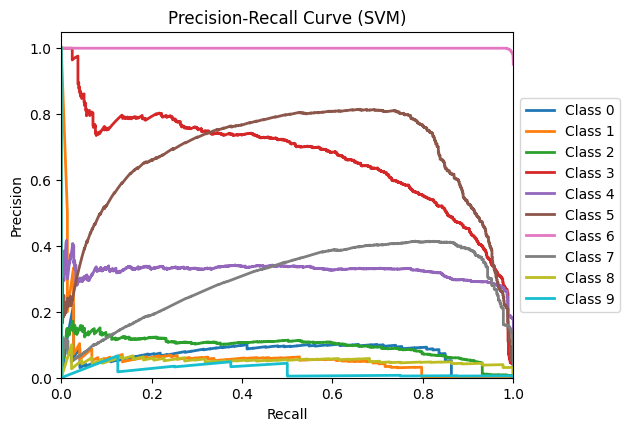

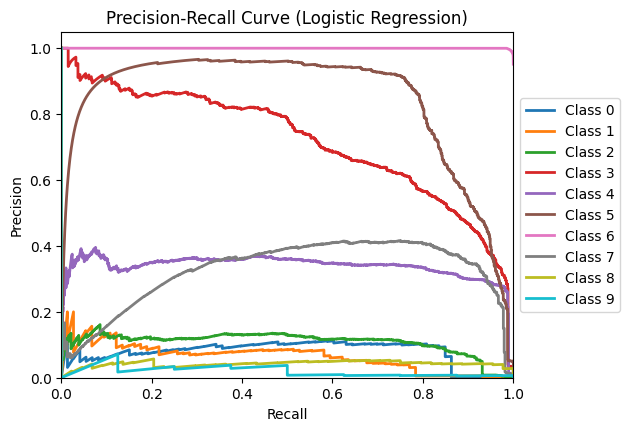

12987

In [23]:
def plot_precision_recall_curve(X, y, classifier, model_name):
    onehotencoder = OneHotEncoder()
    y_onehot = onehotencoder.fit_transform(y.values.reshape(-1,1)).toarray()
    n_classes = y_onehot.shape[1]
    X_train, X_test, y_train, y_test = train_test_split(X, y_onehot, test_size=0.2, random_state=0)
    clf_ovr = OneVsRestClassifier(classifier)
    clf_ovr.fit(X_train, y_train)
    
    if hasattr(clf_ovr, "predict_proba"):
        y_scores = clf_ovr.predict_proba(X_test)
    else:
        y_scores = clf_ovr.decision_function(X_test)
        y_scores = (y_scores - y_scores.min()) / (y_scores.max() - y_scores.min())

    fig, ax = plt.subplots()
    for i in range(n_classes):
        precision, recall, _ = precision_recall_curve(y_test[:, i], y_scores[:, i])
        ax.plot(recall, precision, lw=2, label=f'Class {i}')

    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    ax.set_title(f'Precision-Recall Curve ({model_name})')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
    
rf_model = joblib.load('rf_model.pkl', mmap_mode='r')
svm_model = joblib.load('svm_model.pkl', mmap_mode='r')
logreg_model = joblib.load('logreg_model.pkl', mmap_mode='r')

plot_precision_recall_curve(X_test_scaled, y_test, rf_model, "Random Forest")
plot_precision_recall_curve(X_test_scaled, y_test, svm_model, "SVM")
plot_precision_recall_curve(X_test_scaled, y_test, logreg_model, "Logistic Regression")

# Cleanup
del rf_model, svm_model, logreg_model
gc.collect()

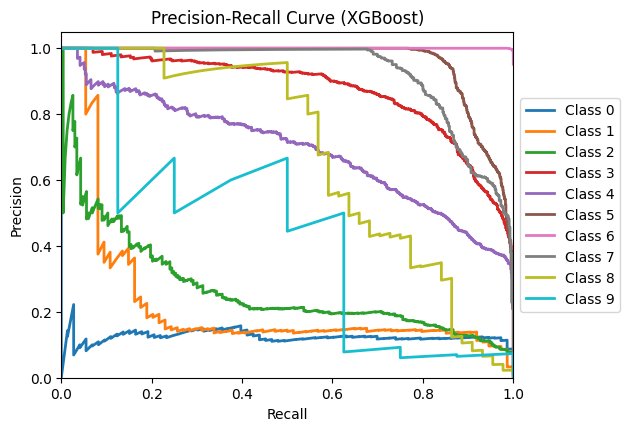

48785

In [31]:
def plot_precision_recall_curve(X, y, classifier, model_name):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    classifier.fit(X_train, y_train)
    
    y_scores = classifier.predict_proba(X_test) if hasattr(classifier, "predict_proba") else classifier.decision_function(X_test)

    # Handling the normalization only if decision_function is used
    if not hasattr(classifier, "predict_proba"):
        y_scores = (y_scores - y_scores.min()) / (y_scores.max() - y_scores.min())

    fig, ax = plt.subplots()
    for i in range(len(np.unique(y))):  # Assuming y is not one-hot encoded
        precision, recall, _ = precision_recall_curve((y_test == i).astype(int), y_scores[:, i])
        ax.plot(recall, precision, lw=2, label=f'Class {i}')

    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    ax.set_title(f'Precision-Recall Curve ({model_name})')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
    
# Load models
xgb_model = joblib.load('xgb_model.pkl', mmap_mode='r')
plot_precision_recall_curve(X_test_scaled, y_test, xgb_model, "XGBoost")

# Cleanup
del xgb_model
gc.collect()

## Addressing Limitation 1: High False Alarm Rate

Assessment of Machine Learning Models in Addressing High False Alarm Rates:

                     Class 0  Class 1  Class 2  Class 3  Class 4  Class 5  Class 6  Class 7  Class 8  Class 9  Average False Positive Rate
Random Forest          0.24%    0.27%    0.09%    0.26%    0.36%    0.03%   10.33%    0.06%    0.03%    0.00%                        1.17%
SVM                    0.30%    0.22%    0.09%    0.34%    1.25%    0.03%    0.03%    0.28%    0.57%    0.38%                        0.35%
Logistic Regression    0.41%    0.25%    0.12%    0.28%    0.99%    0.03%    0.02%    0.37%    0.71%    0.44%                        0.36%
XGBoost                0.12%    0.07%    0.11%    0.35%    0.34%    0.06%    9.11%    0.08%    0.03%    0.00%                        1.03%


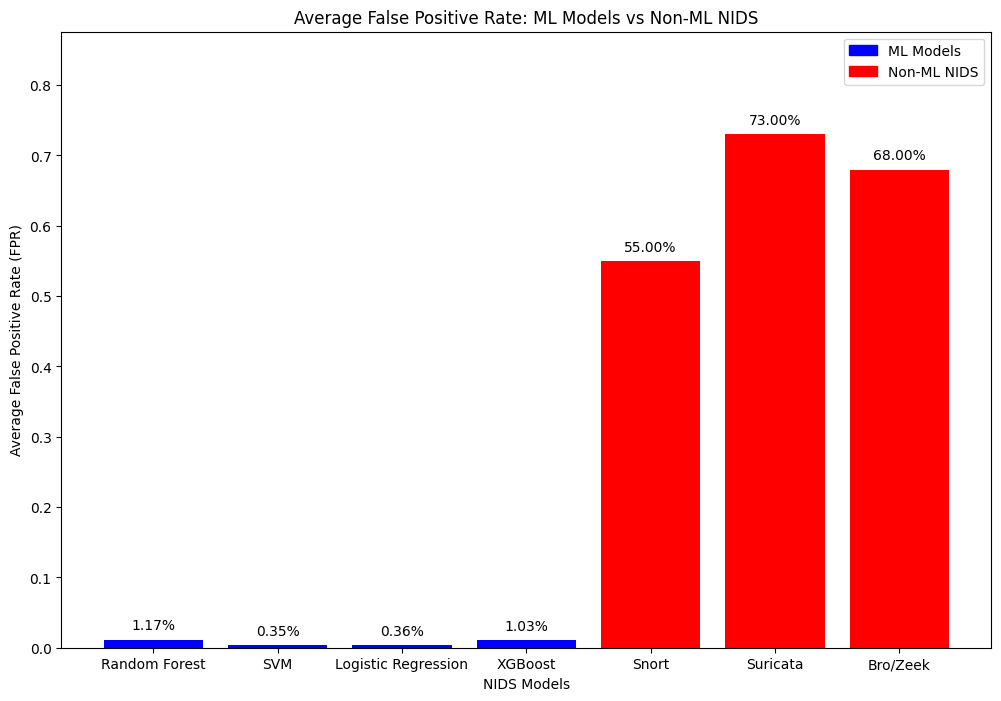

In [33]:
# Dictionary to hold models and their corresponding confusion matrices
confusion_matrices = {
    'Random Forest': rf_cm,
    'SVM': svm_cm,
    'Logistic Regression': logreg_cm,
    'XGBoost': xgb_cm
}

print("Assessment of Machine Learning Models in Addressing High False Alarm Rates:\n")

model_fprs = {}
fpr_data = []

for model_name, cm in confusion_matrices.items():
    # Calculate TP, FP, FN, TN
    TP = np.diag(cm)
    FP = np.sum(cm, axis=0) - TP
    FN = np.sum(cm, axis=1) - TP
    TN = np.sum(cm) - (FP + FN + TP)
    
    # False Positive Rate (False Alarm Rate) for each class 
    FPR = FP / (FP + TN)
    
    # Average False Positive Rate across all classes
    average_FPR = np.mean(FPR)
    model_fprs[model_name] = average_FPR
    
    # Table
    fpr_data.append(np.append(FPR, average_FPR))

# Convert collected data to a DataFrame
index = ['Random Forest', 'SVM', 'Logistic Regression', 'XGBoost']
columns = [f'Class {i}' for i in range(len(FPR))] + ['Average False Positive Rate']
fpr_df = pd.DataFrame(fpr_data, index=index, columns=columns) * 100
formatted_fpr_df = fpr_df.style.format("{:.2f}%")

pd.set_option('display.float_format', '{:.2f}%'.format)
print(fpr_df.to_string())

# Average FPR for non-ML based NIDS based on (Bada et al., 2020)
non_ml_nids_fprs = {
    'Snort': 0.55,
    'Suricata': 0.73,
    'Bro/Zeek': 0.68
}

# Extracting model names and FPRs for plotting
all_models = list(model_fprs.keys()) + list(non_ml_nids_fprs.keys())
all_fprs = list(model_fprs.values()) + list(non_ml_nids_fprs.values())
colors = ['blue']*len(model_fprs) + ['red']*len(non_ml_nids_fprs)

# Plotting the comparison
plt.figure(figsize=(12, 8))
bars = plt.bar(all_models, all_fprs, color=colors)
plt.xlabel('NIDS Models') 
plt.ylabel('Average False Positive Rate (FPR)')
plt.title('Average False Positive Rate: ML Models vs Non-ML NIDS')
plt.ylim(0, max(all_fprs) * 1.2)

for bar in bars:
    yval = bar.get_height() * 100
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, "{:.2f}%".format(yval), ha='center', va='bottom')

# Legend
blue_patch = plt.Rectangle((0,0),1,1, color='blue', label='ML Models')
red_patch = plt.Rectangle((0,0),1,1, color='red', label='Non-ML NIDS')
plt.legend(handles=[blue_patch, red_patch], loc='upper right')

plt.show()

## Addressing Limitation 2: Detecting Unknown or Novel Attacks

In [20]:
# Known attacks contains common attacks, allowing the model to learn from common attack behaviors
# Unknown attacks contain less common and have unique behaviors that represents novel or evolving threats
known_attacks = [0, 1, 4, 5, 6]  # Analysis, Backdoor, Fuzzers, Generic, Normal
unknown_attacks = [2, 3, 6, 7, 8, 9]  # Dos, Exploits, Normal, Reconnaissance, Shellcode, Worms

# Filter the data to create training and testing sets
train_df_known = complete_df[complete_df['attack_cat'].isin(known_attacks)].copy()
test_df_unknown = complete_df[complete_df['attack_cat'].isin(unknown_attacks)].copy()

X_train_known = train_df_known.drop(['attack_cat', 'label'], axis=1)
y_train_known = train_df_known['label']

X_test_unknown = test_df_unknown.drop(['attack_cat', 'label'], axis=1)
y_test_unknown = test_df_unknown['label']

scaler = StandardScaler()
X_train_scaled_k = scaler.fit_transform(X_train_known)
X_test_scaled_u = scaler.transform(X_test_unknown)

def evaluate_model(model, model_name, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"{model_name} Classification Report for Detecting Unknown Attacks")
    print(classification_report(y_test, y_pred, target_names=['Normal', 'Malicious']))
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    print(f"\n{model_name} Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")
    print("\n")
    
    return accuracy

# Train and evaluate Random Forest
rf_model_UA= RandomForestClassifier(n_estimators=100, random_state=0, class_weight='balanced', n_jobs=-1)
rf_accuracy_UA = evaluate_model(rf_model_UA, 'Random Forest', X_train_scaled_k, y_train_known, X_test_scaled_u, y_test_unknown)

# Train and evaluate SVM
svm_model_UA = LinearSVC(dual=False, class_weight='balanced')
svm_accuracy_UA = evaluate_model(svm_model_UA, 'SVM', X_train_scaled_k, y_train_known, X_test_scaled_u, y_test_unknown)

# Train and evaluate Logistic Regression
logreg_model_UA = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=0)
logreg_accuracy_UA = evaluate_model(logreg_model_UA, 'Logistic Regression', X_train_scaled_k, y_train_known, X_test_scaled_u, y_test_unknown)

# Train and evaluate XGBoost
xgb_model_UA = XGBClassifier(
    eval_metric='logloss',
    random_state=0,
    nthread=-1
)
xgb_accuracy_UA = evaluate_model(xgb_model_UA, 'XGBoost', X_train_scaled_k, y_train_known, X_test_scaled_u, y_test_unknown)

# Summary Table
summary_table = pd.DataFrame({
    'Model': ['Random Forest', 'SVM', 'Logistic Regression', 'XGBoost'],
    'Accuracy': [rf_accuracy_UA*100, svm_accuracy_UA*100, logreg_accuracy_UA*100, xgb_accuracy_UA*100]
})

print("Summary Table of Model Accuracies\n")
print(summary_table)

Random Forest Classification Report for Detecting Unknown Attacks
              precision    recall  f1-score   support

      Normal       0.99      1.00      1.00   1958103
   Malicious       0.93      0.77      0.84     48294

    accuracy                           0.99   2006397
   macro avg       0.96      0.88      0.92   2006397
weighted avg       0.99      0.99      0.99   2006397


Random Forest Metrics:
Accuracy: 0.9930
Precision: 0.9927
Recall: 0.9930
F1-score: 0.9927




c:\Users\Jeffson\miniconda3\Lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


SVM Classification Report for Detecting Unknown Attacks
              precision    recall  f1-score   support

      Normal       1.00      0.99      0.99   1958103
   Malicious       0.62      0.98      0.76     48294

    accuracy                           0.99   2006397
   macro avg       0.81      0.98      0.88   2006397
weighted avg       0.99      0.99      0.99   2006397


SVM Metrics:
Accuracy: 0.9853
Precision: 0.9904
Recall: 0.9853
F1-score: 0.9869


Logistic Regression Classification Report for Detecting Unknown Attacks
              precision    recall  f1-score   support

      Normal       1.00      0.99      0.99   1958103
   Malicious       0.62      0.97      0.76     48294

    accuracy                           0.99   2006397
   macro avg       0.81      0.98      0.87   2006397
weighted avg       0.99      0.99      0.99   2006397


Logistic Regression Metrics:
Accuracy: 0.9851
Precision: 0.9901
Recall: 0.9851
F1-score: 0.9866


XGBoost Classification Report for De